## Student Information
**Student ID** 25000148967

**GitHub Repository Link** https://github.com/robwhite-lis/Everything_Counts_Assessment_1

## The Dataset

This is a Notebook about 2 of the UKs favourite topics, trains punctuality and the weather!

The dataset in question is available is the grandiosely named "Table 3138 - Train punctuality at recorded station stops by operator (periodic)" which is available at https://dataportal.orr.gov.uk/statistics/performance/passenger-rail-performance/table-3138-train-punctuality-at-recorded-station-stops-by-operator-periodic/

Let's take a look...

In [46]:
# Here is the boiler plate code we use to read in the raw data from GitHub
#

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import io
import requests
import matplotlib.pyplot as plt
# seaborn is a better tool for this with more examples 
import seaborn as sns

df_url = 'https://raw.githubusercontent.com/robwhite-lis/Everything_Counts_Assessment_1/refs/heads/main/Train_punctuality.csv'
url_content = requests.get(df_url, verify = False).content
df_trains = pd.read_csv(io.StringIO(url_content.decode('utf-8')))

In [47]:
df_trains.head()

,Time Period,Operator,Number of recorded station stops,Early,On Time within 59 seconds,Time to 3,Time to 5,Time to 10,Time to 15,Time to 20,...,On time within 59 seconds MAA,Time to 3 MAA,Time to 5 MAA,Time to 10 MAA,Time to 15 MAA,Time to 20 MAA,Time to 30 MAA,15 minutes plus MAA,20 minutes plus MAA,30 minutes plus MAA
0,Apr 2014 to Mar 2015 (Period 01),Great Britain,4736697,35.64,68.70,88.43,94.38,98.23,99.17,99.55,...,[z],[z],[z],[z],[z],[z],[z],[z],[z],[z]
1,Apr 2014 to Mar 2015 (Period 02),Great Britain,5061146,35.05,67.70,87.50,93.69,97.91,98.98,99.42,...,[z],[z],[z],[z],[z],[z],[z],[z],[z],[z]
2,Apr 2014 to Mar 2015 (Period 03),Great Britain,5084203,35.00,67.67,87.43,93.65,97.89,98.99,99.45,...,[z],[z],[z],[z],[z],[z],[z],[z],[z],[z]
3,Apr 2014 to Mar 2015 (Period 04),Great Britain,5123892,34.09,66.16,86.44,93.08,97.67,98.87,99.37,...,[z],[z],[z],[z],[z],[z],[z],[z],[z],[z]
4,Apr 2014 to Mar 2015 (Period 05),Great Britain,5131680,32.78,63.95,84.38,91.54,97.03,98.56,99.20,...,[z],[z],[z],[z],[z],[z],[z],[z],[z],[z]


## Understanding the Data

This dataset measures train punctiuality by when the train arrives into one of its expected stops (aka stations). Each row of the dataset corresponds to one "period's" worth of data. A period roughly equates to a month, but not quite, as there are 13 of them in a year. (There are actually 28 days in each). Also note, the year runs from April to March!

The "Number of recorded station stops" is therefore the total number of stations a specific train operator would have made in a given period.

The next set of data is the information about the actual time a train arrived at a specified stop in relation to the timetable. So we have "Early", "On Time within 59 seconds", "Time to 3" (which means trains that were **up to** 3 minutes late), "Time to 5" etc. all the way up to trains that were 30 minutes late. It's important to note that this data is cumulative, so e.g. a train that is "up to 3" minutes late is also "up to 5" minutes late so would be included in both sets of figures. This has to be taken into account in the following analysis

Finally there is further data which is showing trains falling into different bands of lateness according to government guildelines, and moving average data for the time buckets listed above. These will be considered out of scope for this notebook, but could make for interesting analysis in the future.

In [48]:
df_trains.dtypes

Time Period                             object
Operator                                object
Number of recorded station stops         int64
Early                                   object
On Time within 59 seconds               object
Time to 3                               object
Time to 5                               object
Time to 10                              object
Time to 15                              object
Time to 20                              object
Time to 30                              object
15 minutes plus                         object
20 minutes plus                         object
30 minutes plus                         object
MAT Number of recorded station stops     int64
Early MAA                               object
On time within 59 seconds MAA           object
Time to 3 MAA                           object
Time to 5 MAA                           object
Time to 10 MAA                          object
Time to 15 MAA                          object
Time to 20 MA

# Cleansing the dataset

Data cleansing is the bane of any data analyst, so we should get to it.

First of all let's clean up the date period into something more useable. I propose stick with the 13 periods for now but break out that data into its own field. For the "Time Period" year component, I am going to define a field called "Start_Year" so we'll label data with respect to that year.  

In [49]:
# Here we are using a regular expression. 
# The d{4} looks for the first 4 digits in the string which we are defining as "Start_Year"
# The .* means ignore anything until...
# you get to the word Period  and then look for the next 2 digits you find (Periods are formateed 01, 02, etc.)
df_trains[["Start_Year", "Period"]] = df_trains["Time Period"].str.extract(r'(\d{4}).*Period (\d{2})')

Lets do some further cleansing to clean up the data types. This is boilerplate code to iterate over and convert a number of fields. The errors="coerce" replaces failures with NaN.

We'll create a  new clean dataframe, then identify which columns we want to "fix" and iterate over them

In [50]:
df_trains_clean = df_trains[['Start_Year', 'Period', 'Operator', 'Number of recorded station stops', 'Early',
       'On Time within 59 seconds', 'Time to 3', 'Time to 5', 'Time to 10',
       'Time to 15', 'Time to 20', 'Time to 30' ]].copy()

In [51]:
numeric_cols = [
    'Start_Year', 'Period', 'Number of recorded station stops', 'Early',
    'On Time within 59 seconds', 'Time to 3', 'Time to 5', 'Time to 10',
    'Time to 15', 'Time to 20', 'Time to 30'
]

df_trains_clean[numeric_cols] = df_trains_clean[numeric_cols].apply(
    pd.to_numeric, errors='coerce'
)

Now let's check our work

In [52]:
df_trains_clean.head()

,Start_Year,Period,Operator,Number of recorded station stops,Early,On Time within 59 seconds,Time to 3,Time to 5,Time to 10,Time to 15,Time to 20,Time to 30
0,2014,1,Great Britain,4736697,35.64,68.70,88.43,94.38,98.23,99.17,99.55,99.83
1,2014,2,Great Britain,5061146,35.05,67.70,87.50,93.69,97.91,98.98,99.42,99.77
2,2014,3,Great Britain,5084203,35.00,67.67,87.43,93.65,97.89,98.99,99.45,99.79
3,2014,4,Great Britain,5123892,34.09,66.16,86.44,93.08,97.67,98.87,99.37,99.76
4,2014,5,Great Britain,5131680,32.78,63.95,84.38,91.54,97.03,98.56,99.20,99.69


In [53]:
df_trains_clean.dtypes

Start_Year                            int64
Period                                int64
Operator                             object
Number of recorded station stops      int64
Early                               float64
On Time within 59 seconds           float64
Time to 3                           float64
Time to 5                           float64
Time to 10                          float64
Time to 15                          float64
Time to 20                          float64
Time to 30                          float64
dtype: object

## Augmenting the Dataset

Now let's add a Season column. I want to do this to see if the different seasons have an impact on train punctuality. Let's see if there is any data behind the "wrong kind of leaves on the line" mantra of late running trains

Bearing in mind that the periods run April to March, and there are 13 of them, I've made the following assignments which roughly translate as

| Period         | Season | Corresponding Months (approximate)               |
|----------------|--------|--------------------------------------------------|
| Period 1 - 3   | Spring | (April, May, June)                               |
| Period 4 - 6   | Summer | (July, August, September)                        |
| Period 7 - 9   | Autumn | (October, November, December)                    |
| Period 10 - 13 | Winter | (January, February, March and a bit of April)   |
r


In [81]:
# this code uses bins, a convenient way of allocation across some arbitary groupings
# bins lower bound is excluded, upper bound included
# Note we have 1 more point that bins to anchor us
bins = [0,3,6,9,13]
labels = ["Spring", "Summer", "Autumn", "Winter"]
df_trains_clean["Season"] = pd.cut(df_trains_clean["Period"], bins=bins, labels=labels)

Let's check our work again...

In [55]:
df_trains_clean.columns

Index(['Start_Year', 'Period', 'Operator', 'Number of recorded station stops',
       'Early', 'On Time within 59 seconds', 'Time to 3', 'Time to 5',
       'Time to 10', 'Time to 15', 'Time to 20', 'Time to 30', 'Season'],
      dtype='object')

In [56]:
df_trains_clean.head()

,Start_Year,Period,Operator,Number of recorded station stops,Early,On Time within 59 seconds,Time to 3,Time to 5,Time to 10,Time to 15,Time to 20,Time to 30,Season
0,2014,1,Great Britain,4736697,35.64,68.70,88.43,94.38,98.23,99.17,99.55,99.83,Spring
1,2014,2,Great Britain,5061146,35.05,67.70,87.50,93.69,97.91,98.98,99.42,99.77,Spring
2,2014,3,Great Britain,5084203,35.00,67.67,87.43,93.65,97.89,98.99,99.45,99.79,Spring
3,2014,4,Great Britain,5123892,34.09,66.16,86.44,93.08,97.67,98.87,99.37,99.76,Summer
4,2014,5,Great Britain,5131680,32.78,63.95,84.38,91.54,97.03,98.56,99.20,99.69,Summer


In [57]:
df_trains_clean.dtypes

Start_Year                             int64
Period                                 int64
Operator                              object
Number of recorded station stops       int64
Early                                float64
On Time within 59 seconds            float64
Time to 3                            float64
Time to 5                            float64
Time to 10                           float64
Time to 15                           float64
Time to 20                           float64
Time to 30                           float64
Season                              category
dtype: object

## Final Cleanse

Finally we'll remove the "Great Britain", "England and Wales" and "Scotland" Operators as they are aggregators.

We'll also remove 2025 data as it is incomplete.

In [58]:
df_trains_clean = df_trains_clean[df_trains_clean["Operator"] != "Great Britain"]
df_trains_clean = df_trains_clean[df_trains_clean["Operator"] != "England and Wales"]
df_trains_clean = df_trains_clean[df_trains_clean["Operator"] != "Scotland"]

In [59]:
df_trains_clean = df_trains_clean[df_trains_clean["Start_Year"] != 2025]

In [60]:
# Check we've cleaned out the Operators
df_trains_clean["Operator"].unique()

array(['Avanti West Coast', 'c2c', 'Caledonian Sleeper',
       'Chiltern Railways', 'CrossCountry', 'East Midlands Railway',
       'Elizabeth line', 'Govia Thameslink Railway', 'Grand Central',
       'Great Western Railway', 'Greater Anglia', 'Heathrow Express',
       'Hull Trains', 'London North Eastern Railway', 'London Overground',
       'Lumo', 'Merseyrail', 'Northern Trains', 'ScotRail',
       'South Western Railway', 'Southeastern', 'TfW Rail',
       'TransPennine Express', 'West Midlands Trains'], dtype=object)

In [61]:
# and Years
df_trains_clean["Start_Year"].unique()

array([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])

## Normalizing the data

We now need to normalize the data, as we are going to start aggregating it across years, seasons operators etc. Because each row in the original data is for a different number of recorded stops we can't simply sum the averages and divide by a number of rows. Instead, we have to calculate an actual ontime_count for each row which we can use later. 

In [62]:
# Now we have a problem because each row in a given year has an on-time percentage expressed based on a different number of rows for that peroid.
# So we need to normalize so lets calculate an ontime count from the number of journeys * % ontime
df_trains_clean["ontime_count"] = (
    df_trains_clean["On Time within 59 seconds"] / 100 *
    df_trains_clean["Number of recorded station stops"]
)

In [63]:
df_trains_clean.head()

,Start_Year,Period,Operator,Number of recorded station stops,Early,On Time within 59 seconds,Time to 3,Time to 5,Time to 10,Time to 15,Time to 20,Time to 30,Season,ontime_count
450,2014,1,Avanti West Coast,48987,30.46,54.31,76.20,85.66,94.32,96.94,97.94,98.92,Spring,26604.8397
451,2014,2,Avanti West Coast,51186,21.39,40.98,61.02,72.68,85.11,90.59,93.59,96.79,Spring,20976.0228
452,2014,3,Avanti West Coast,52831,25.91,47.50,70.23,81.91,92.28,95.78,97.56,98.85,Spring,25094.7250
453,2014,4,Avanti West Coast,53748,26.11,48.36,71.03,81.42,91.26,95.04,97.00,98.71,Summer,25992.5328
454,2014,5,Avanti West Coast,52971,24.01,45.18,66.63,77.61,88.83,93.25,95.47,97.63,Summer,23932.2978


## At last, the analysis

Let's first look at some overall statistics which operators had the best "On time" record by year. For our purposes we'll define year as the calendar year the data started in, as defined by "Start_Year".

We'll create a new dataframe so that we can sum ontime_counts over the year. This has the added benefit of helping to maintain our sanity...

In [64]:
# Create a new dataset, and build up the vaiues from the granular rows
df_trains_year = (
 df_trains_clean.groupby(["Start_Year", "Operator"], as_index=False)
 .agg(total_stops=("Number of recorded station stops", "sum"),
     total_ontime=("ontime_count", "sum")
)
)

# Now create the new "% on time" 
df_trains_year["pct_ontime"] = (
    df_trains_year["total_ontime"] / df_trains_year["total_stops"] * 100
)

In [65]:
df_trains_year.head()

,Start_Year,Operator,total_stops,total_ontime,pct_ontime
0,2014,Avanti West Coast,684538,319103.1079,46.615835
1,2014,Caledonian Sleeper,66,44.9988,68.180000
2,2014,Chiltern Railways,956796,721154.6307,75.371828
3,2014,CrossCountry,1198051,571699.9726,47.719168
4,2014,East Midlands Railway,1147745,706973.7492,61.596761


Let's see who were the top 5 train operators in each year...

In [66]:
df_top5 = (

    df_trains_year
        .sort_values(["Start_Year", "pct_ontime"], ascending=[True, False])
        .groupby("Start_Year")
        .head(5)[["Start_Year", "Operator", "pct_ontime"]]
)
    

In [67]:
df_top5

,Start_Year,Operator,pct_ontime
22,2014,c2c,86.400998
10,2014,Heathrow Express,80.661286
2,2014,Chiltern Railways,75.371828
14,2014,Merseyrail,71.260713
17,2014,South Western Railway,70.267451
45,2015,c2c,84.389774
33,2015,Heathrow Express,80.394721
28,2015,Elizabeth line,72.088344
25,2015,Chiltern Railways,71.697376
40,2015,South Western Railway,69.491445


and the the bottom 5

In [68]:
df_bottom5 = (

    df_trains_year
        .sort_values(["Start_Year", "pct_ontime"], ascending=[True, True])
        .groupby("Start_Year")
        .head(5)[["Start_Year", "Operator", "pct_ontime"]]
)
    

In [69]:
df_bottom5

,Start_Year,Operator,pct_ontime
20,2014,TransPennine Express,43.486392
0,2014,Avanti West Coast,46.615835
3,2014,CrossCountry,47.719168
12,2014,London North Eastern Railway,53.159540
11,2014,Hull Trains,54.345027
43,2015,TransPennine Express,43.976448
23,2015,Avanti West Coast,48.659254
26,2015,CrossCountry,48.776255
34,2015,Hull Trains,50.831706
35,2015,London North Eastern Railway,51.118749


## Let's do some plots

Let's take this idea a step further and plot the best and worst performers each year. We'll start with a generic plot of the very best and the very worst...

In [70]:
# Just sorting in the order we want and taking one row with head(1) will do it...
best_per_year = (
    df_top5
    .sort_values(["Start_Year", "pct_ontime"], ascending=[True, False])
    .groupby("Start_Year")
    .head(1)
)

worst_per_year = (
    df_bottom5
    .sort_values(["Start_Year", "pct_ontime"], ascending=[True, True])
    .groupby("Start_Year")
    .head(1)
)


Now let's draw the graph

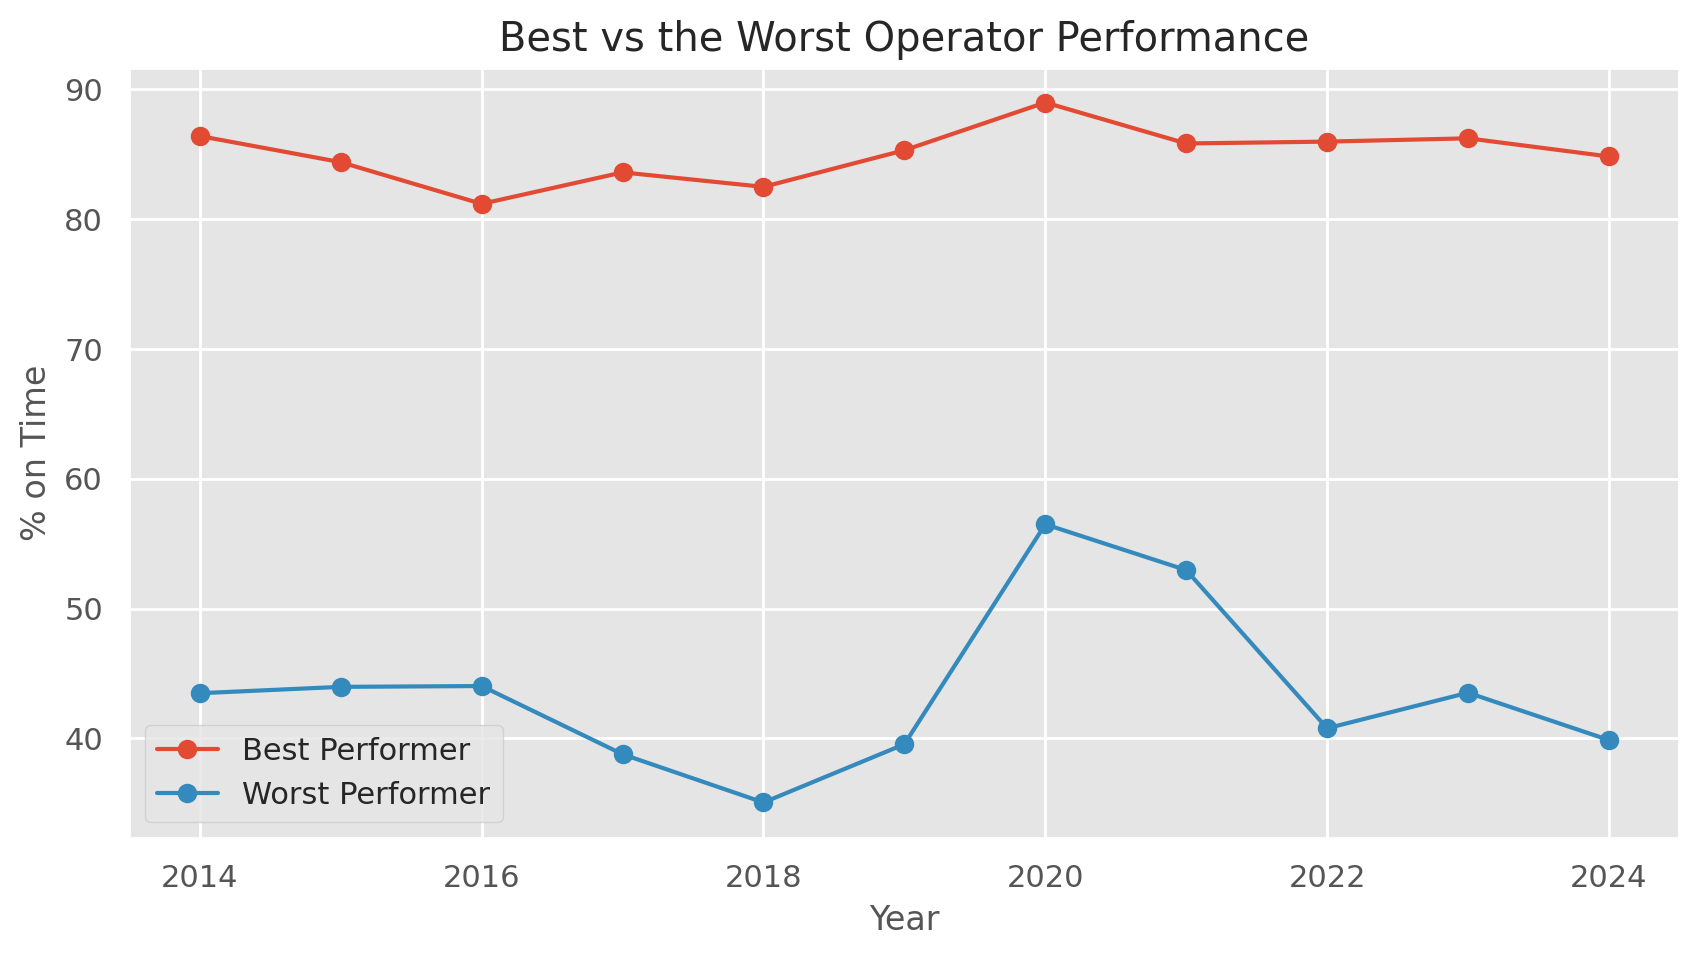

In [71]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10,5)

# plt.hist(plot_data, bins = plot_data, edgecolor = 'black', linewidth = 1.2)

# Plot the best performer line
plt.plot(
    best_per_year["Start_Year"],
    best_per_year["pct_ontime"],
    marker="o",
    label="Best Performer"
)

# Plot the worst performer line
plt.plot(
    worst_per_year["Start_Year"],
    worst_per_year["pct_ontime"],
    marker="o",
    label="Worst Performer"
)



plt.xlabel("Year")
plt.ylabel("% on Time")
plt.title("Best vs the Worst Operator Performance")
plt.legend()

plt.show();

The plot above shows us the absolute best and worst, but doesn't name and shame. Which Operators were the best and worst?

The plot above shows us the absolute best and worst, but doesn't name and shame. Which Operators were the best and worst? A scatterplot will show the spread.

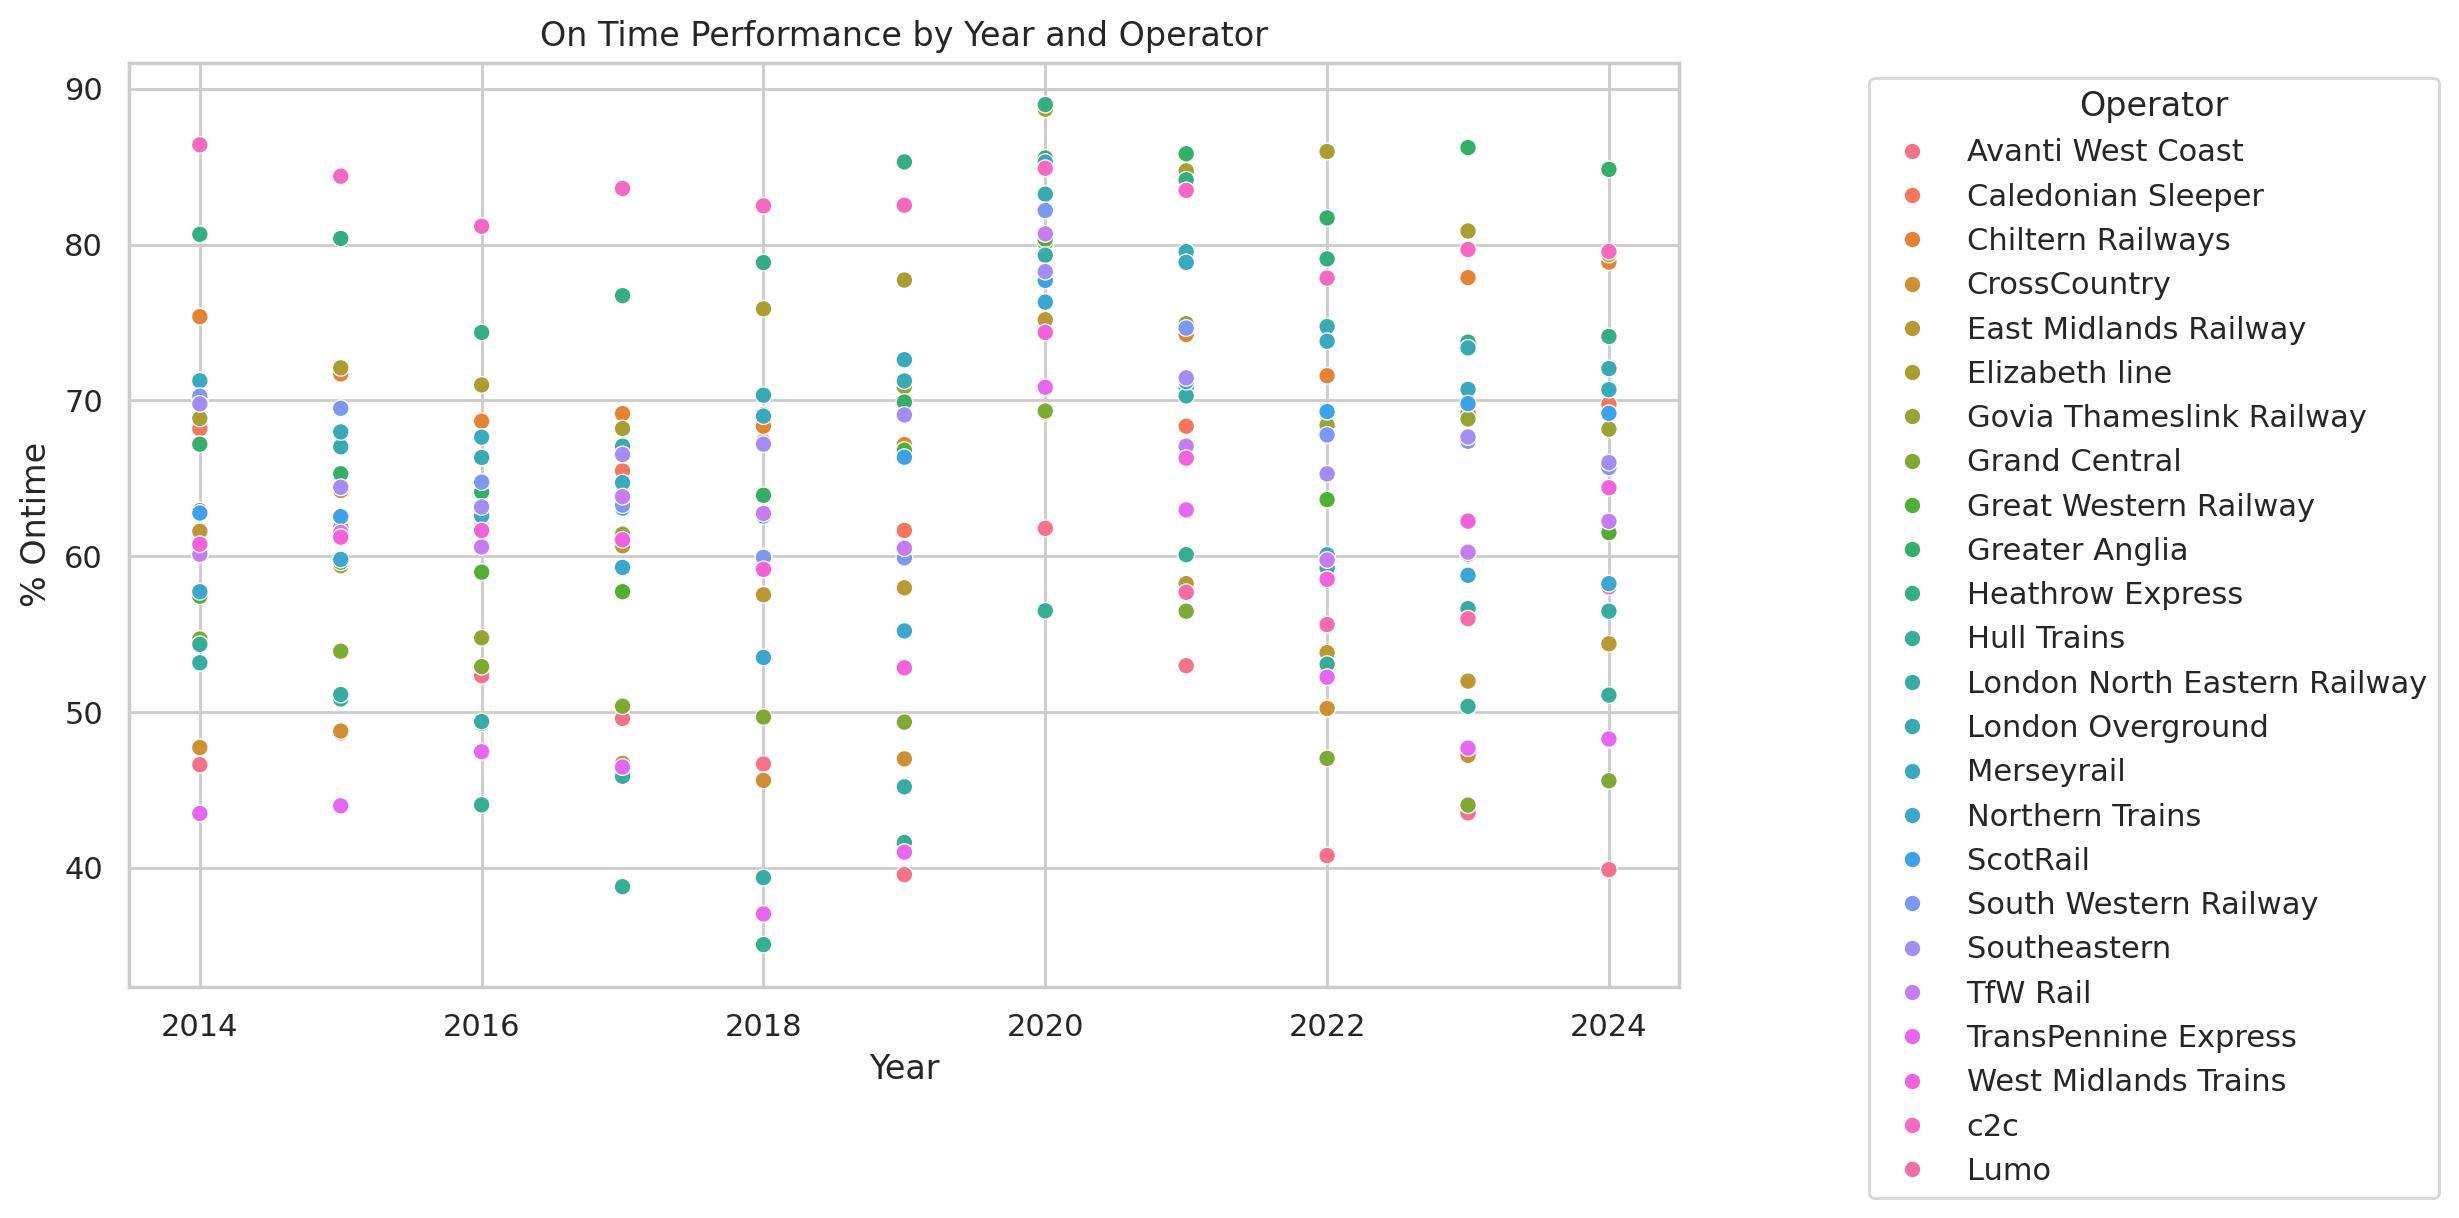

In [82]:
# scatterplot code based on example code
plt.figure(figsize=(10,6))

sns.scatterplot(
    data=df_trains_year,
    x="Start_Year",
    y="pct_ontime",
    hue="Operator"
)


plt.title("On Time Performance by Year and Operator")
plt.xlabel("Year")
plt.ylabel("% Ontime")
plt.legend(title="Operator", loc="upper right", bbox_to_anchor=(1.5, 1))
plt.show()

# Seasonal Data
Let's now start looking at seasonal data

First of all we'll look at how the different Operators perform across different seasons aggregated across all the 11 years we have

In [73]:
# Once again, start with the granular data and normalize the data to calculate % ontime
df_trains_season_operator = (
 df_trains_clean.groupby(["Season", "Operator"], as_index=False)
 .agg(total_stops=("Number of recorded station stops", "sum"),
     total_ontime=("ontime_count", "sum")
)
)

# Now create the new "% on time" 
df_trains_season_operator["pct_ontime"] = (
    df_trains_season_operator["total_ontime"] / df_trains_season_operator["total_stops"] * 100
)



In [74]:
# Now let's clean up to just the columns we need.
df_trains_season_operator = df_trains_season_operator[["Season", "Operator","total_stops", "pct_ontime"]]

# Need to recalculate our ontime count again as we've removed the Operator group-by
df_trains_season_operator["ontime_count"] = df_trains_season_operator["pct_ontime"] / 100 * df_trains_season_operator["total_stops"]

Let's check our work for just one operator...

In [75]:
df_trains_season_operator[df_trains_season_operator["Operator"] == "c2c"]

,Season,Operator,total_stops,pct_ontime,ontime_count
23,Spring,c2c,3784239,84.454251,3.195951e+06
47,Summer,c2c,3937769,82.279799,3.239988e+06
71,Autumn,c2c,3859848,79.335615,3.062234e+06
95,Winter,c2c,5032314,83.275086,4.190664e+06


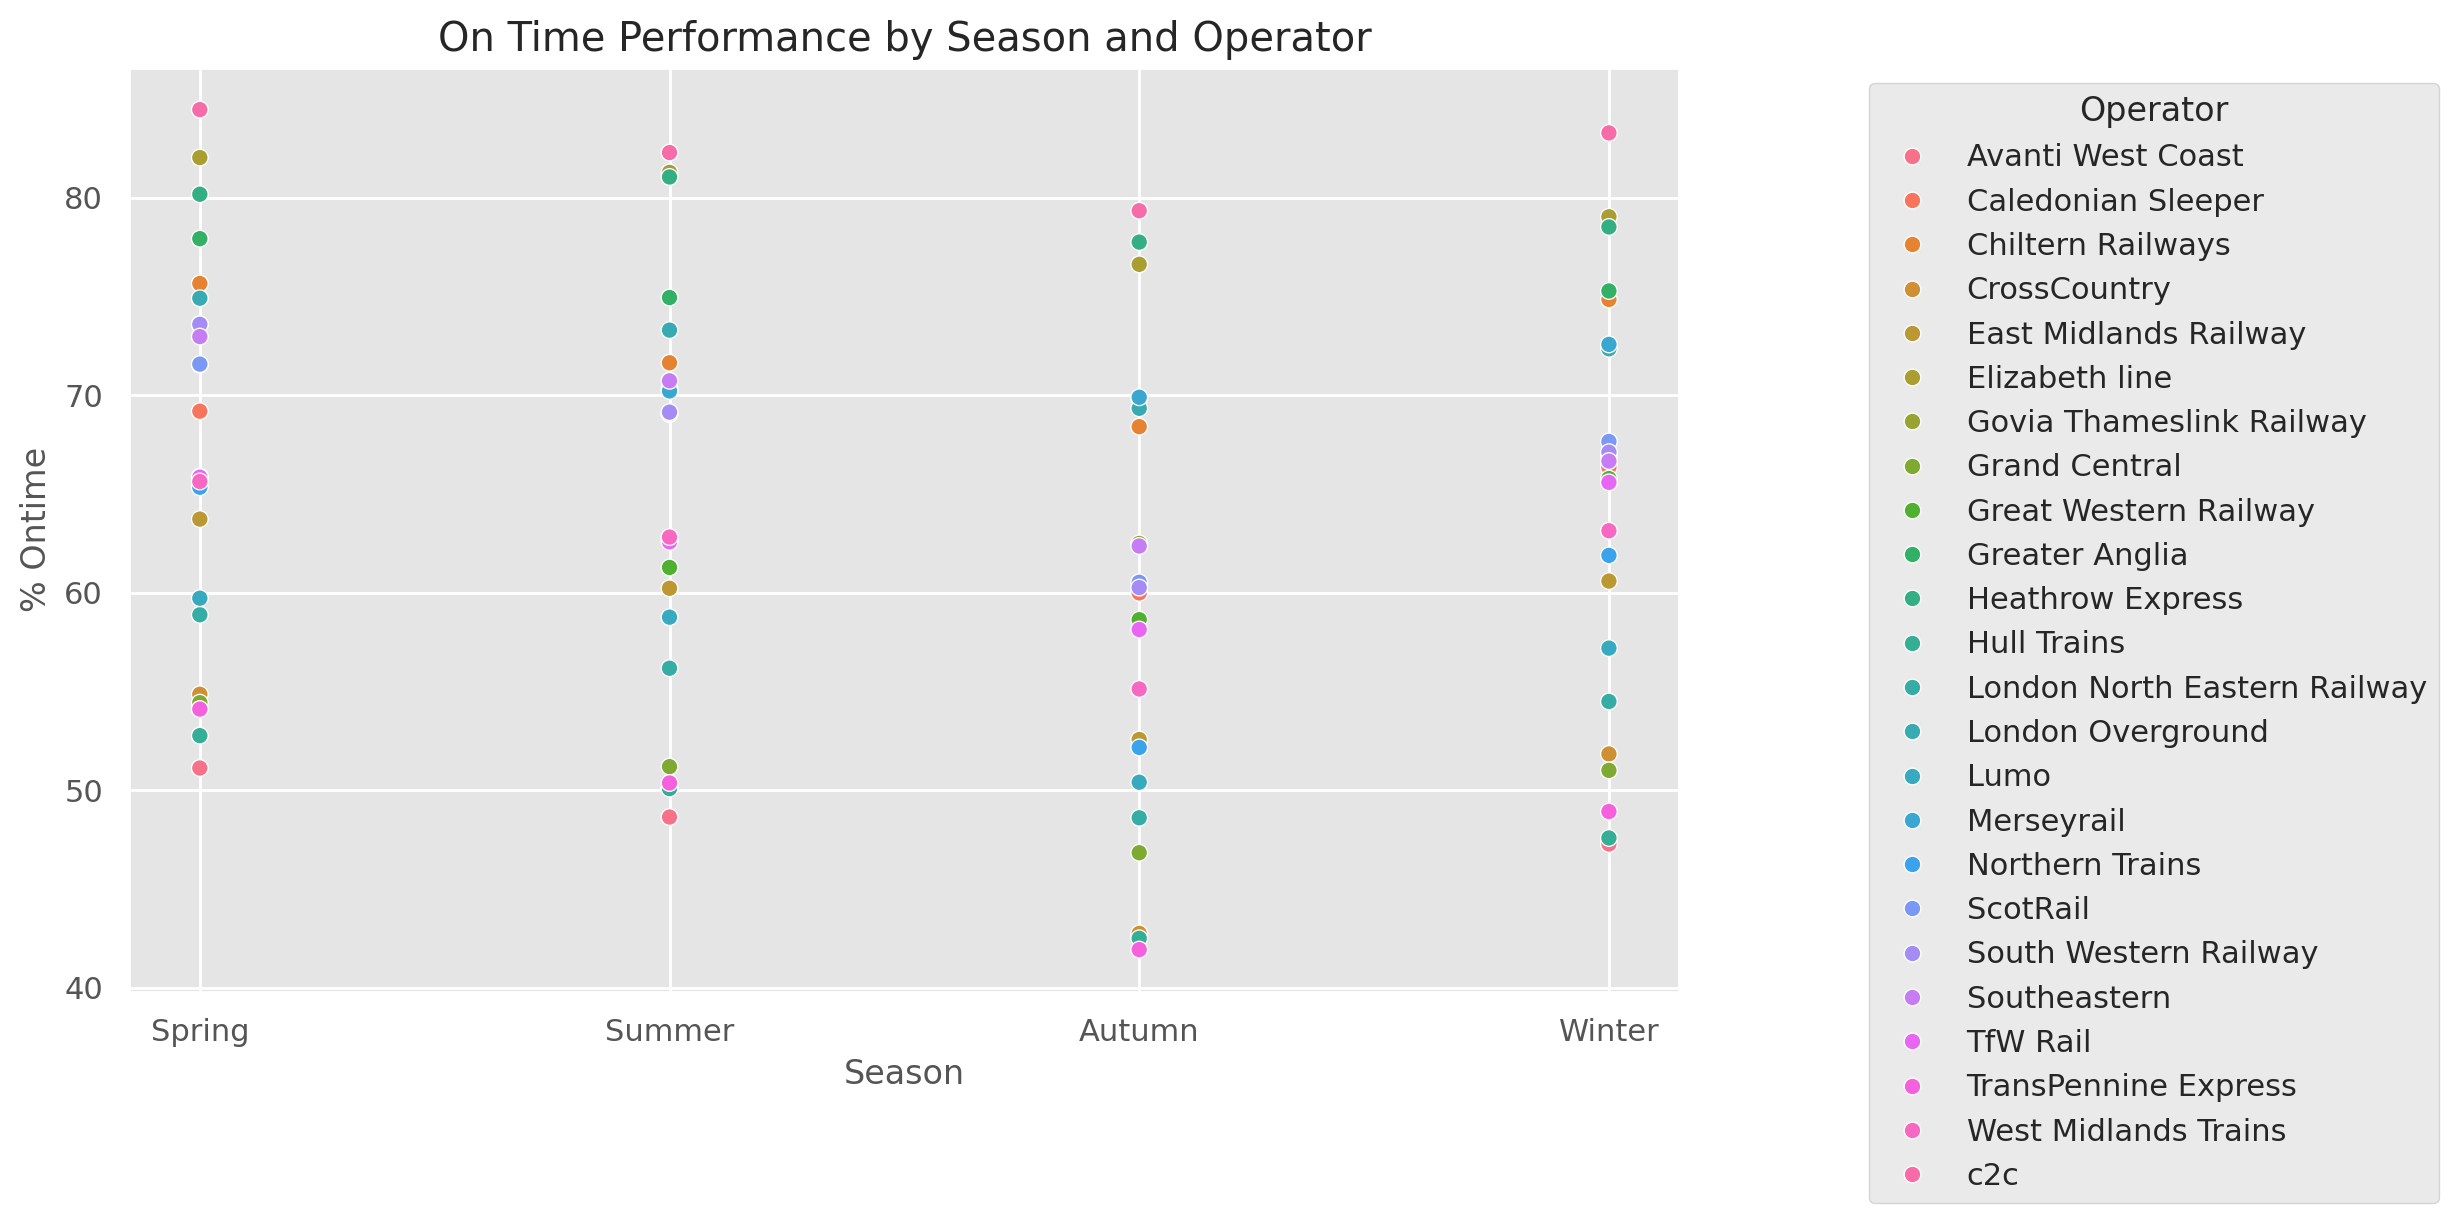

In [76]:
plt.figure(figsize=(10,6))

sns.scatterplot(
    data=df_trains_season_operator,
    x="Season",
    y="pct_ontime",
    hue="Operator",
)


plt.title("On Time Performance by Season and Operator")
plt.xlabel("Season")
plt.ylabel("% Ontime")
plt.legend(title="Operator", loc="upper right", bbox_to_anchor=(1.5, 1))
plt.show()

We identified the top and bottom 5 performers earlier, but let's also look at the spread for each operator.

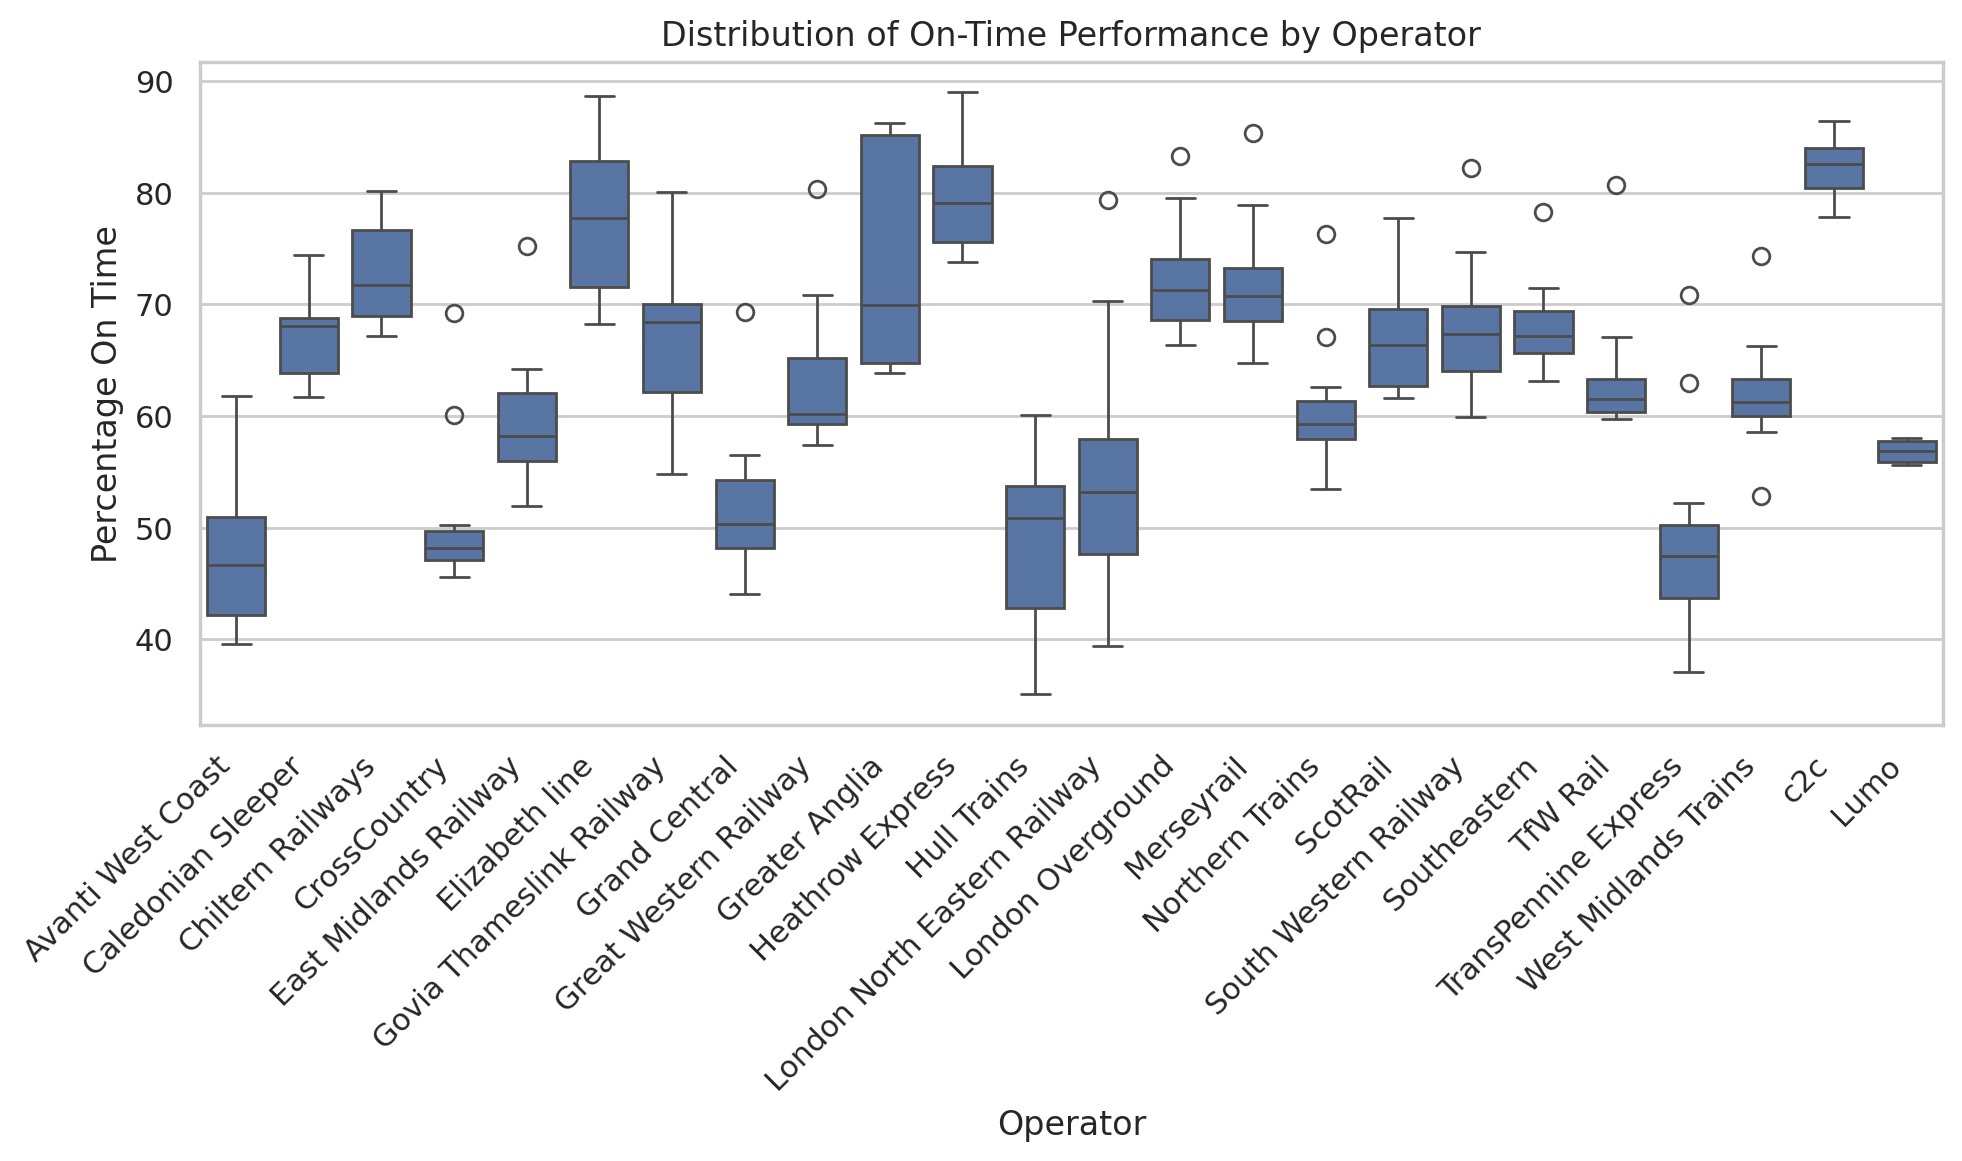

In [77]:
# Set an optional style
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.boxplot(
    data=df_trains_year,
    x="Operator",
    y="pct_ontime"
)

# Format the x axis labels all they don't look right
plt.xticks(rotation=45, ha='right')

plt.title("Distribution of On-Time Performance by Operator")
plt.xlabel("Operator")
plt.ylabel("Percentage On Time")

plt.tight_layout()
plt.show()

Great Anglia have the widest spread between the 25th and 75th percentile. As you can see the interquartile spread varies significantly between Operators.

Let's see if any of the "bottom 5" Operators have improved year on year....
(There are more than 5 Operators, because the bottom 5 each year changed).

In [78]:
# First find all the operators that have figured at least once in the bottom 5
df_allyears_bottom5 = df_bottom5["Operator"].unique()
df_allyears_bottom5

array(['TransPennine Express', 'Avanti West Coast', 'CrossCountry',
       'London North Eastern Railway', 'Hull Trains', 'Grand Central',
       'Lumo', 'East Midlands Railway'], dtype=object)

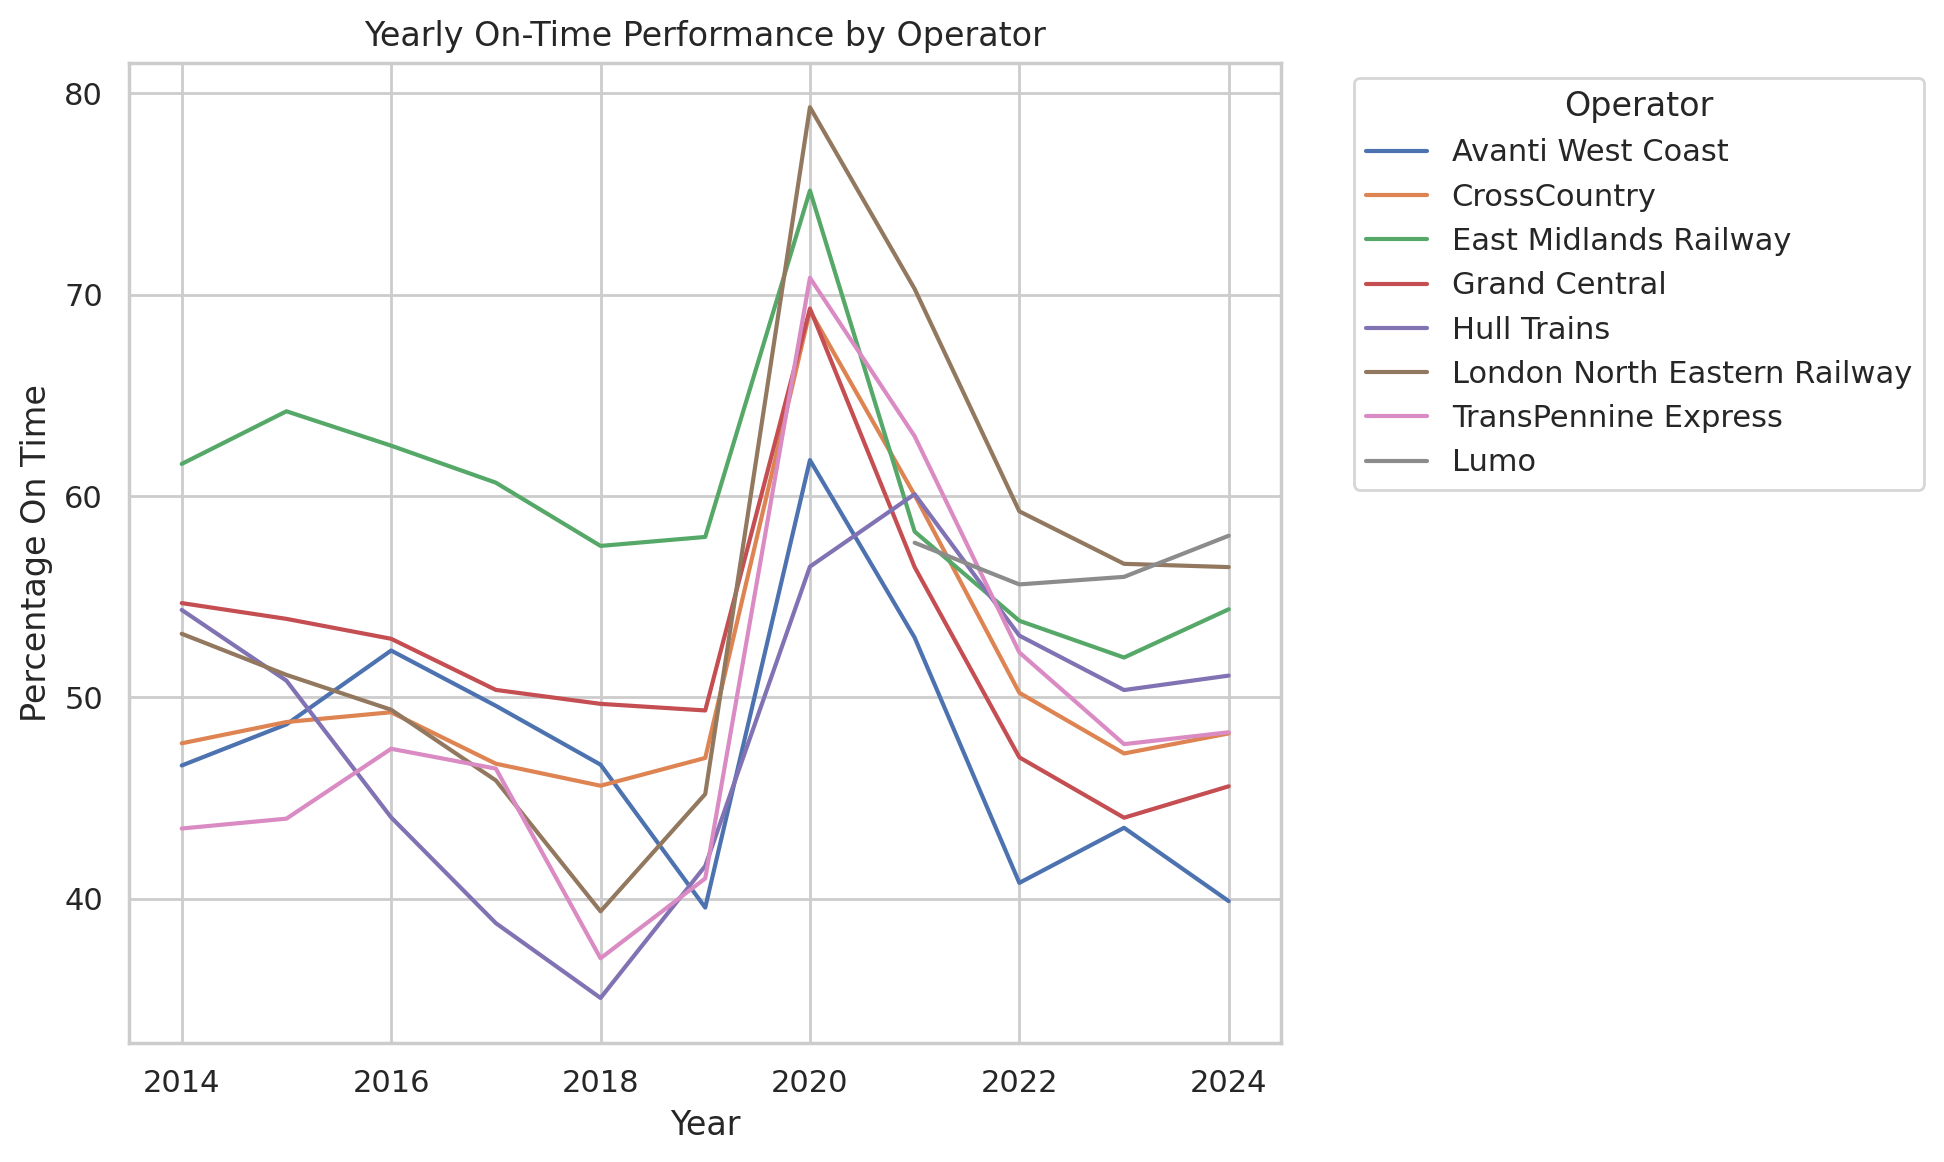

In [79]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.lineplot(
    data=df_trains_year[df_trains_year["Operator"].isin(df_allyears_bottom5)],
    x="Start_Year",
    y="pct_ontime",
    hue="Operator"
)


plt.title("Yearly On-Time Performance by Operator")
plt.xlabel("Year")
plt.ylabel("Percentage On Time")
plt.legend(title="Operator", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

... not really! There is no discernable pattern across the 8 Operators who fell into the bottom 5 across the years. Interesting that there were improvements across the board around 2020, the epidemic years. Note not all Operators were in existance for all the years, e.g. Lumo

## Finally...

Let's remove the Operator Lens for a moment. Which Season does the entire rail network struggle with most?

In [80]:

# Same process but without the operator grouping

df_trains_season = (
 df_trains_clean.groupby(["Season"], as_index=False)
 .agg(total_stops=("Number of recorded station stops", "sum"),
     total_ontime=("ontime_count", "sum")
)
)

# Normalize and Now create the new "% on time"
df_trains_season["pct_ontime"] = (
    df_trains_season["total_ontime"] / df_trains_season["total_stops"] * 100
)

df_trains_season[["Season", "pct_ontime"]]

,Season,pct_ontime
0,Spring,70.823678
1,Summer,68.030284
2,Autumn,61.429872
3,Winter,67.266383


So from the above, Autumn is clearly the least reliable season. In our definition that is approx. October, November & December. Maybe there is something to be said for "leaves on the line" :-)